In [1]:
# Cell 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For normalization
from sklearn.preprocessing import StandardScaler

# For model evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset (update file_path as needed)
file_path = "/Users/premdoshi/Desktop/PM_Accelerator/GlobalWeatherRepository.csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows
print("DataFrame shape:", df.shape)
display(df.head())


DataFrame shape: (56906, 41)


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [2]:
# Cell 2: Data Cleaning, Outlier Handling & Normalization

# 1. Missing Values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Fill missing values: For numerical columns use median; for categorical use mode.
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# 2. Date Conversion
if 'last_updated_epoch' in df.columns:
    df['last_updated'] = pd.to_datetime(df['last_updated_epoch'], unit='s')
else:
    df['last_updated'] = pd.to_datetime(df['last_updated'])

# Convert other time-related columns if they exist
for col in ['sunrise', 'sunset', 'moonrise', 'moonset']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# 3. Outlier Handling: Cap temperature columns at 1st and 99th percentiles
for col in ['temperature_celsius', 'temperature_fahrenheit']:
    if col in df.columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)

# 4. Normalization (for modeling or feature analysis)
# Normalize numeric columns except for time series target 'temperature_celsius' (if forecasting in original scale)
features_to_scale = [col for col in num_cols if col not in ['temperature_celsius', 'last_updated_epoch']]
scaler = StandardScaler()
df_scaled = df.copy()
if features_to_scale:
    df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("Data cleaning, outlier handling, and normalization complete.")


Missing Values:
 country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone              

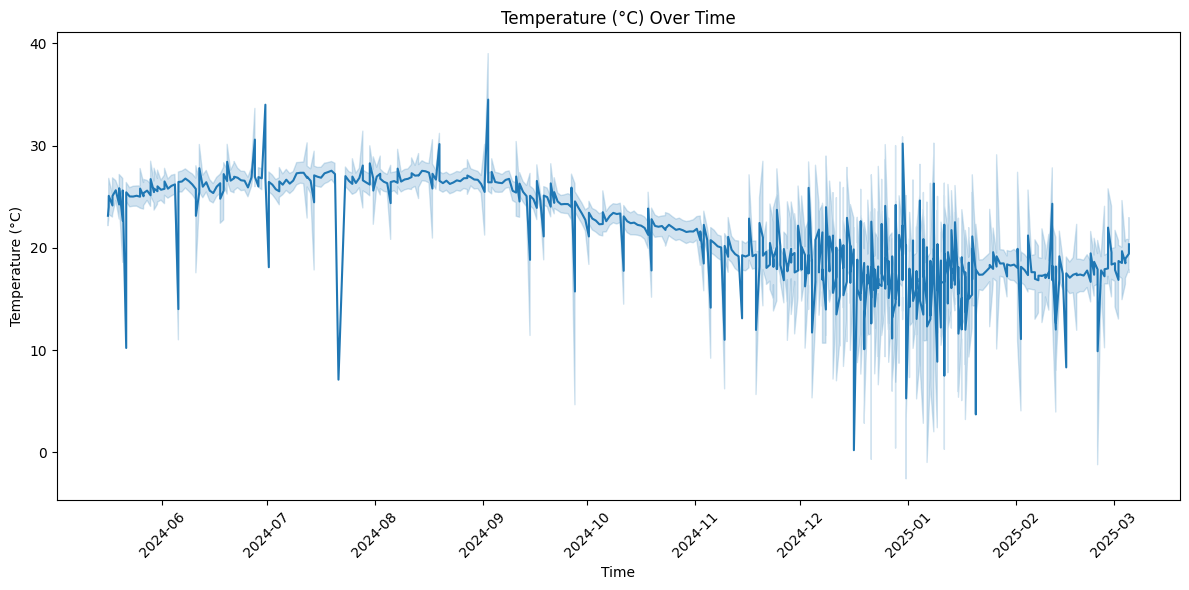

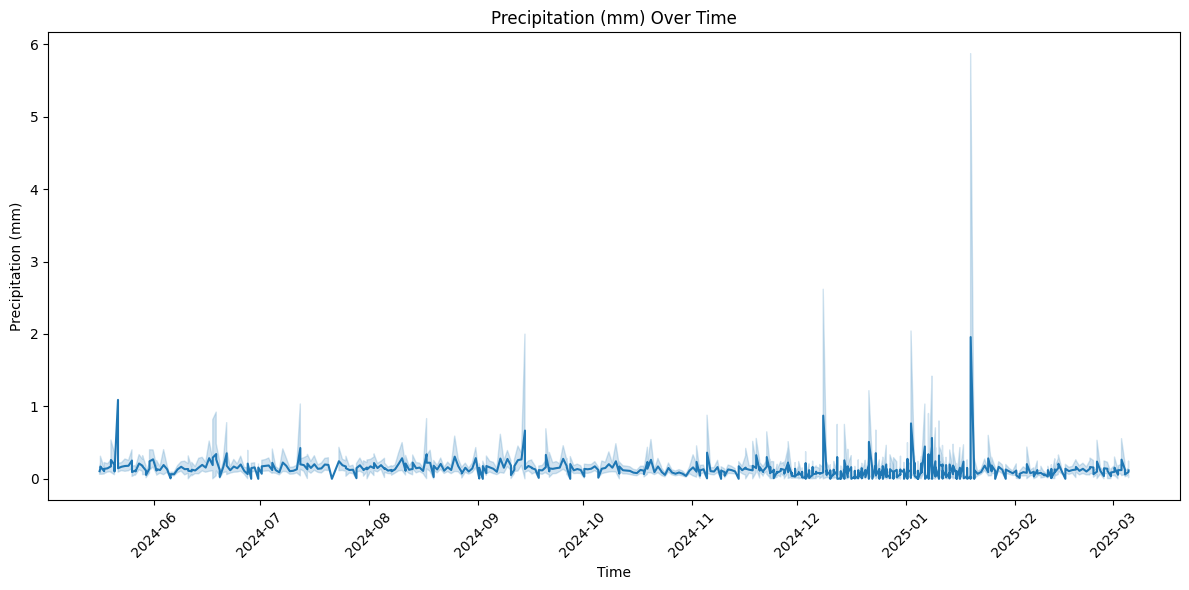

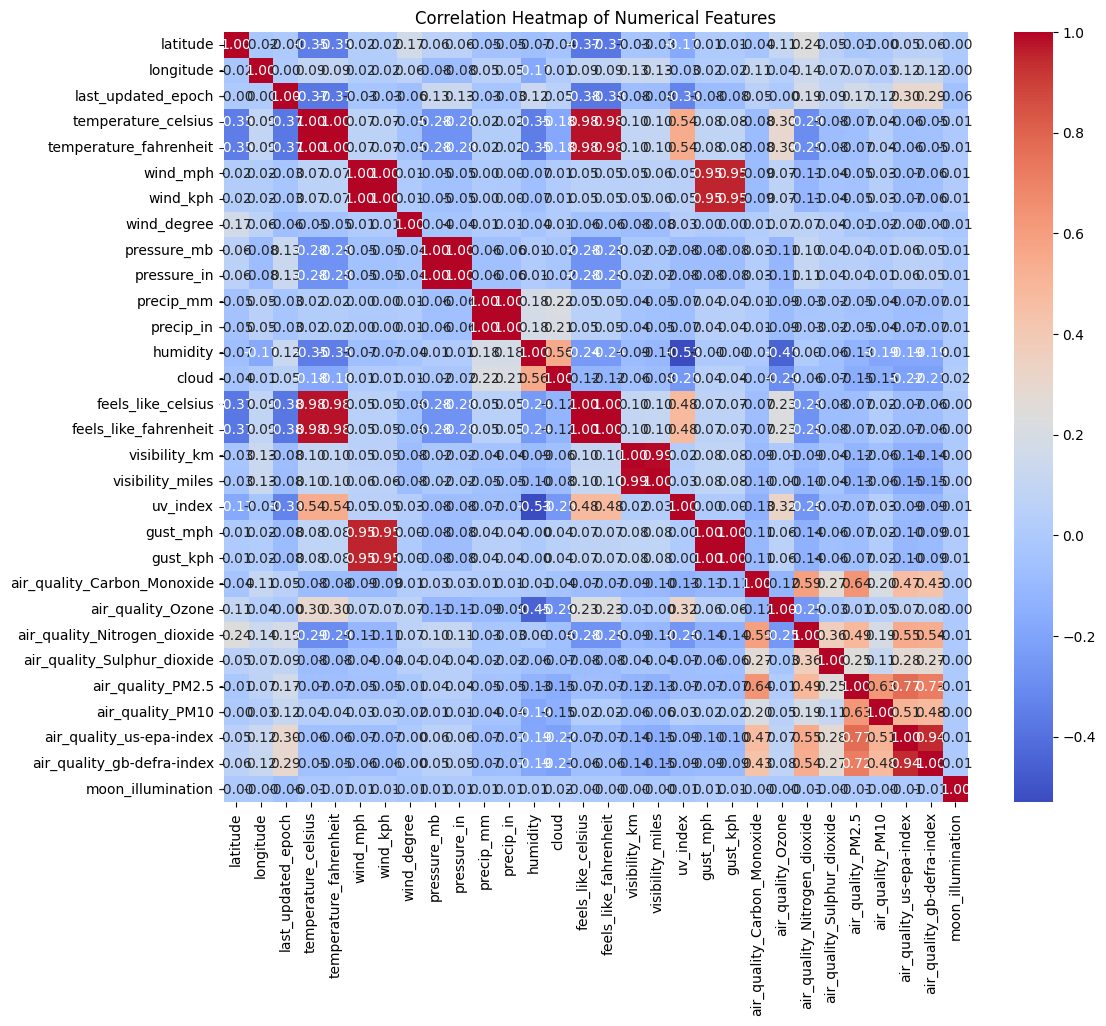

In [3]:
# Cell 3: Exploratory Data Analysis (EDA)

# Temperature trend over time
plt.figure(figsize=(12,6))
sns.lineplot(x='last_updated', y='temperature_celsius', data=df)
plt.title("Temperature (°C) Over Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Precipitation trend (if available)
if 'precip_mm' in df.columns:
    plt.figure(figsize=(12,6))
    sns.lineplot(x='last_updated', y='precip_mm', data=df)
    plt.title("Precipitation (mm) Over Time")
    plt.xlabel("Time")
    plt.ylabel("Precipitation (mm)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Correlation heatmap of numerical features
plt.figure(figsize=(12,10))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


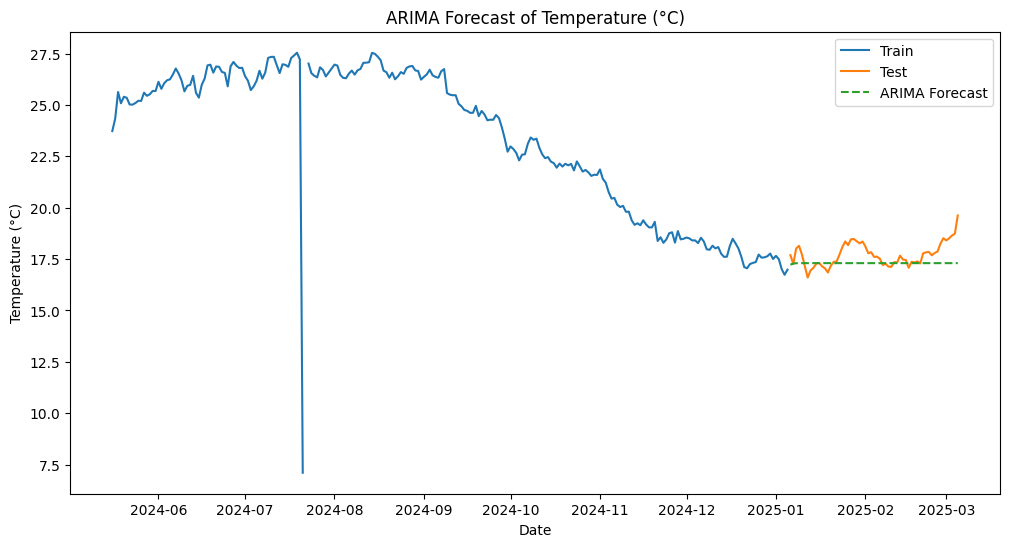

ARIMA MSE: 0.48692229832847156
ARIMA MAE: 0.5170705151510009
ARIMA RMSE: 0.6977981787941779


In [4]:
# Cell 4: Time Series Forecasting with ARIMA

from statsmodels.tsa.arima.model import ARIMA

# Set datetime as index and sort the DataFrame
df_ts = df.set_index('last_updated').sort_index()

# Resample to daily average temperature (target variable)
daily_temp = df_ts['temperature_celsius'].resample('D').mean()

# Split data into training (80%) and test (20%)
train_size = int(len(daily_temp) * 0.8)
train = daily_temp.iloc[:train_size]
test = daily_temp.iloc[train_size:]

# Build and fit ARIMA model (order=(1,1,1) as starting point)
model_fit = ARIMA(train, order=(1, 1, 1)).fit()

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))

# Plot ARIMA forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.title("ARIMA Forecast of Temperature (°C)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# Evaluate ARIMA performance: MSE, MAE, RMSE
arima_mse = mean_squared_error(test, forecast)
arima_mae = mean_absolute_error(test, forecast)
arima_rmse = np.sqrt(arima_mse)
print("ARIMA MSE:", arima_mse)
print("ARIMA MAE:", arima_mae)
print("ARIMA RMSE:", arima_rmse)


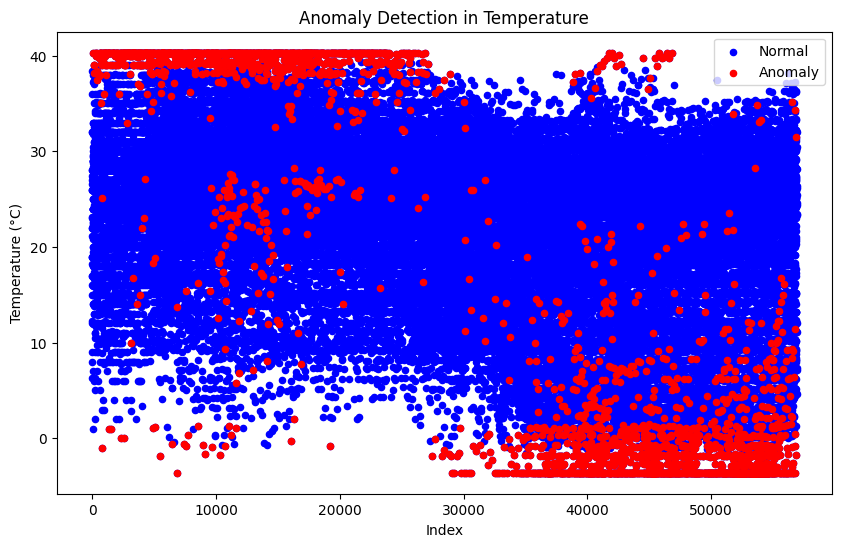

Number of anomalies detected: 2846


In [5]:
# Cell 5: Advanced EDA – Anomaly Detection

from sklearn.ensemble import IsolationForest

# Select features for anomaly detection (e.g., temperature and humidity)
features = ['temperature_celsius', 'humidity']
if all(col in df.columns for col in features):
    df_anomaly = df[features].copy()
    
    # Fit Isolation Forest (with contamination rate ~5%)
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    df_anomaly['anomaly'] = iso_forest.fit_predict(df_anomaly[features])
    
    # Extract anomalies (label -1 indicates anomaly)
    anomalies = df_anomaly[df_anomaly['anomaly'] == -1]
    
    # Visualize anomalies in temperature readings
    plt.figure(figsize=(10,6))
    plt.scatter(df_anomaly.index, df_anomaly['temperature_celsius'], label='Normal', color='blue', s=20)
    plt.scatter(anomalies.index, anomalies['temperature_celsius'], label='Anomaly', color='red', s=20)
    plt.title("Anomaly Detection in Temperature")
    plt.xlabel("Index")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.show()
    
    print("Number of anomalies detected:", anomalies.shape[0])
else:
    print("Required features for anomaly detection not found.")


Aligned Test Length: 59
Aligned Ensemble Length: 0
Cannot compute ensemble performance: Series length mismatch or no data.


/Users/premdoshi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


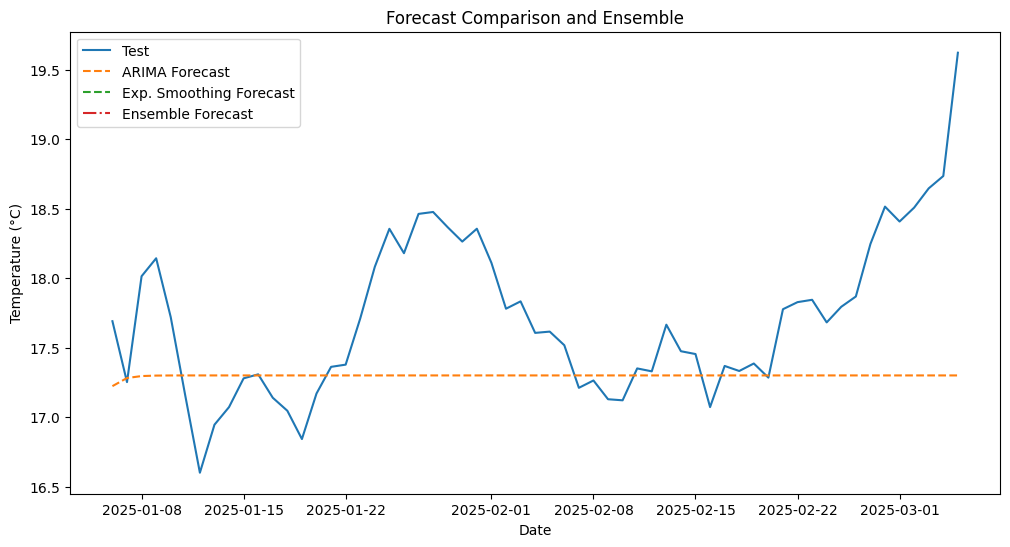

In [6]:
# Cell 6: Forecasting with Multiple Models & Ensemble

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Handle missing values in test: fill forward then backward
test = test.fillna(method='ffill').fillna(method='bfill')

# Fit Exponential Smoothing model on training data
es_model = ExponentialSmoothing(train, trend='add', seasonal=None)
es_fit = es_model.fit()

# Forecast using Exponential Smoothing and convert to Series with test index
es_forecast = es_fit.forecast(steps=len(test))
es_forecast = pd.Series(es_forecast, index=test.index).fillna(method='ffill').fillna(method='bfill')

# ARIMA forecast: already computed in Cell 4; convert to Series with test index
forecast_values = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast_values, index=test.index).fillna(method='ffill').fillna(method='bfill')

# Ensemble forecast: average ARIMA and Exponential Smoothing predictions
ensemble_forecast = (forecast + es_forecast) / 2

# Convert series to numeric to ensure no issues
test_numeric = pd.to_numeric(test, errors='coerce')
ensemble_numeric = pd.to_numeric(ensemble_forecast, errors='coerce')

# Align indices and drop any remaining NaNs
common_index = test_numeric.index.intersection(ensemble_numeric.index)
test_aligned = test_numeric.loc[common_index].dropna()
ensemble_aligned = ensemble_numeric.loc[common_index].dropna()

print("Aligned Test Length:", len(test_aligned))
print("Aligned Ensemble Length:", len(ensemble_aligned))

# Compute ensemble performance metrics if aligned series are non-empty and equal in length
if len(test_aligned) > 0 and len(test_aligned) == len(ensemble_aligned):
    ensemble_mse = mean_squared_error(test_aligned.values, ensemble_aligned.values)
    ensemble_mae = mean_absolute_error(test_aligned.values, ensemble_aligned.values)
    ensemble_rmse = np.sqrt(ensemble_mse)
    print("Ensemble MSE:", ensemble_mse)
    print("Ensemble MAE:", ensemble_mae)
    print("Ensemble RMSE:", ensemble_rmse)
else:
    print("Cannot compute ensemble performance: Series length mismatch or no data.")

# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.plot(test.index, es_forecast, label='Exp. Smoothing Forecast', linestyle='--')
plt.plot(test.index, ensemble_forecast, label='Ensemble Forecast', linestyle='-.')
plt.title("Forecast Comparison and Ensemble")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


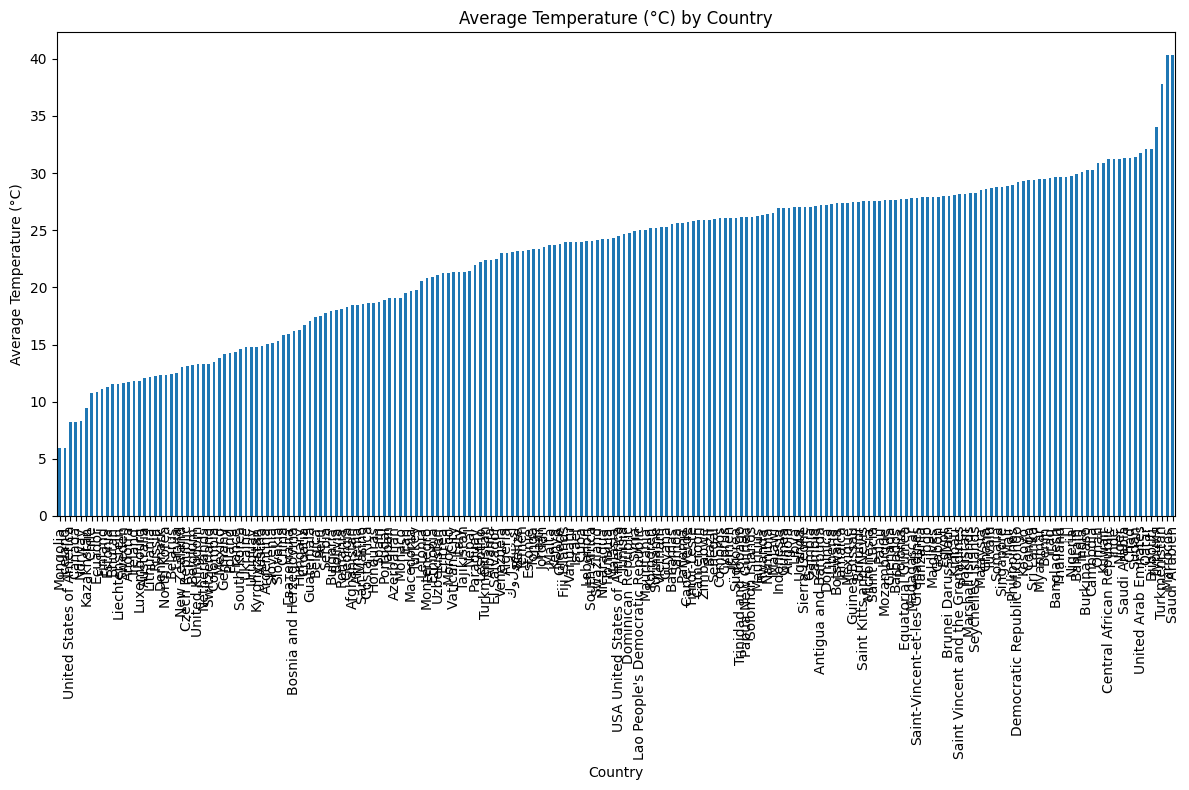

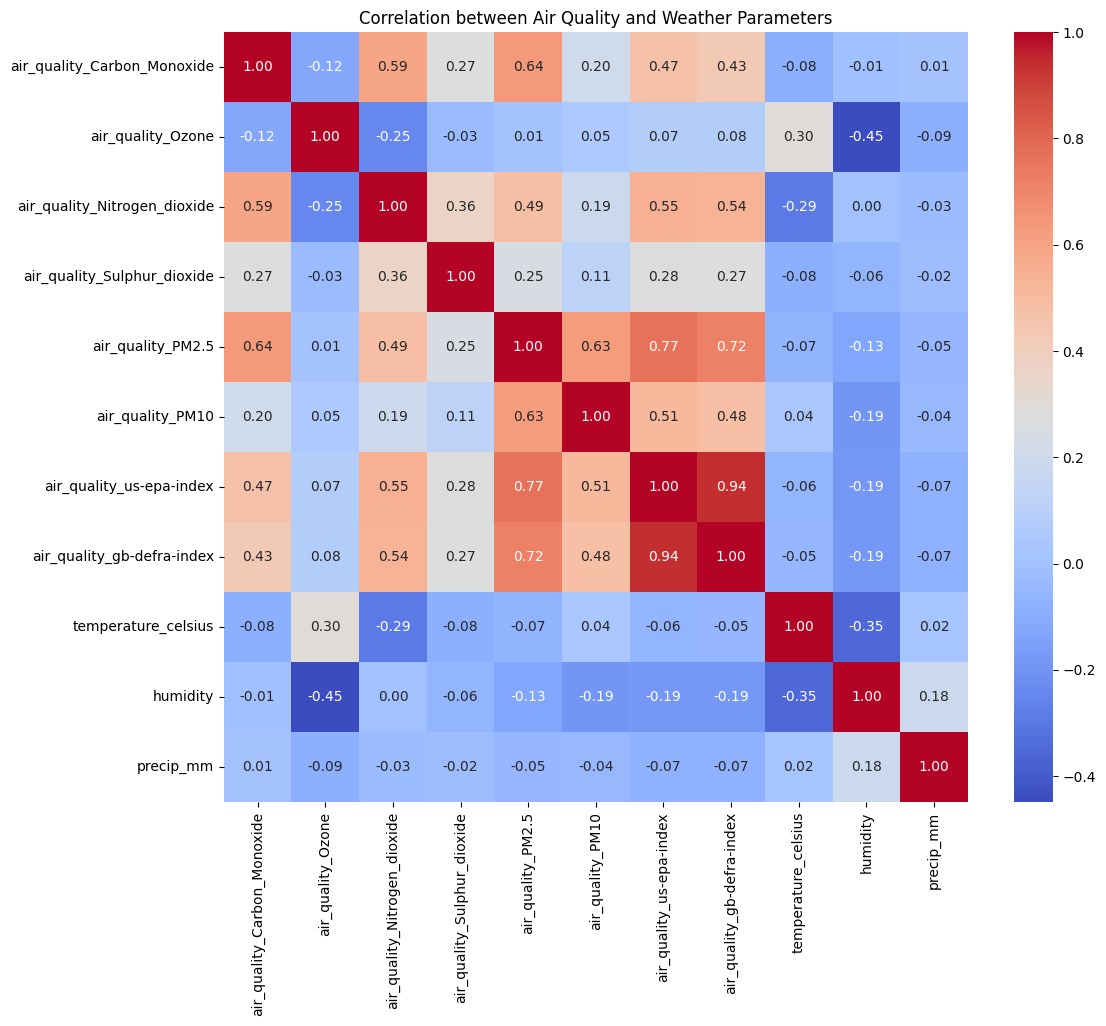

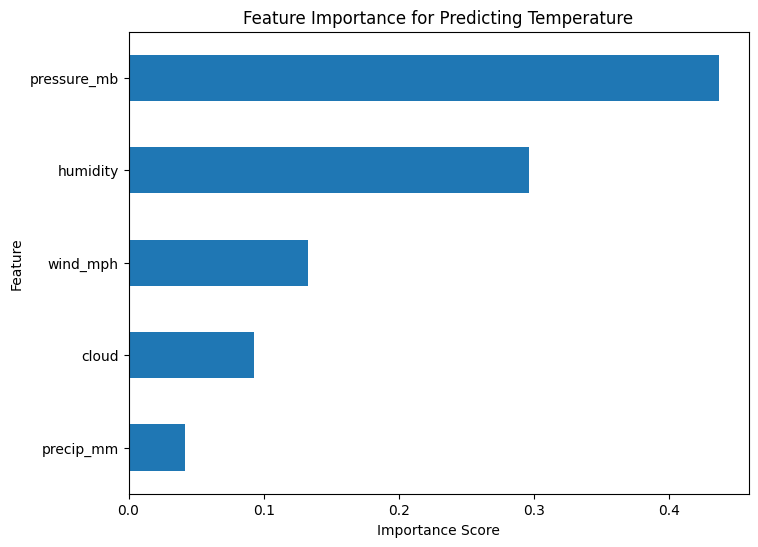

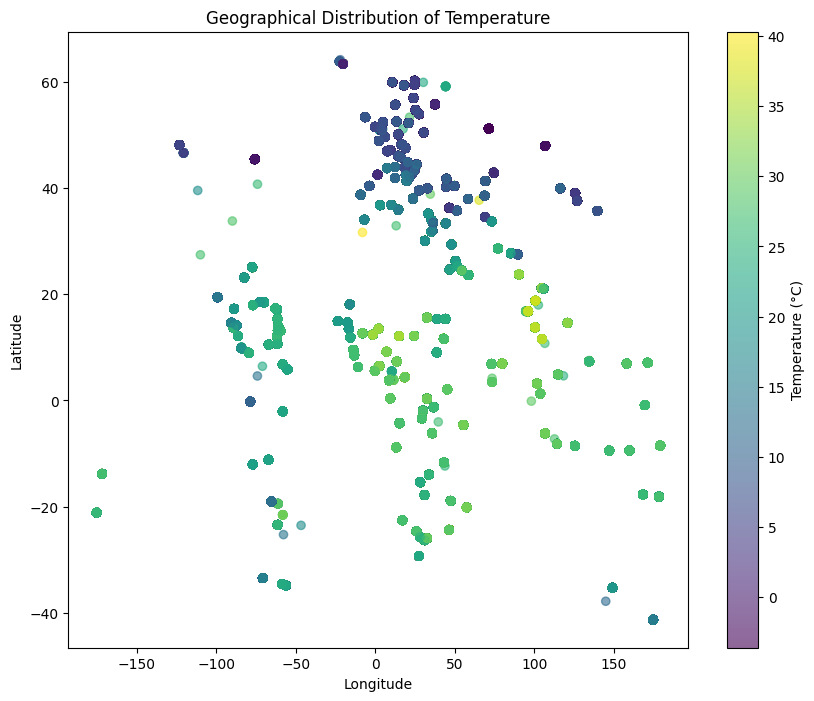

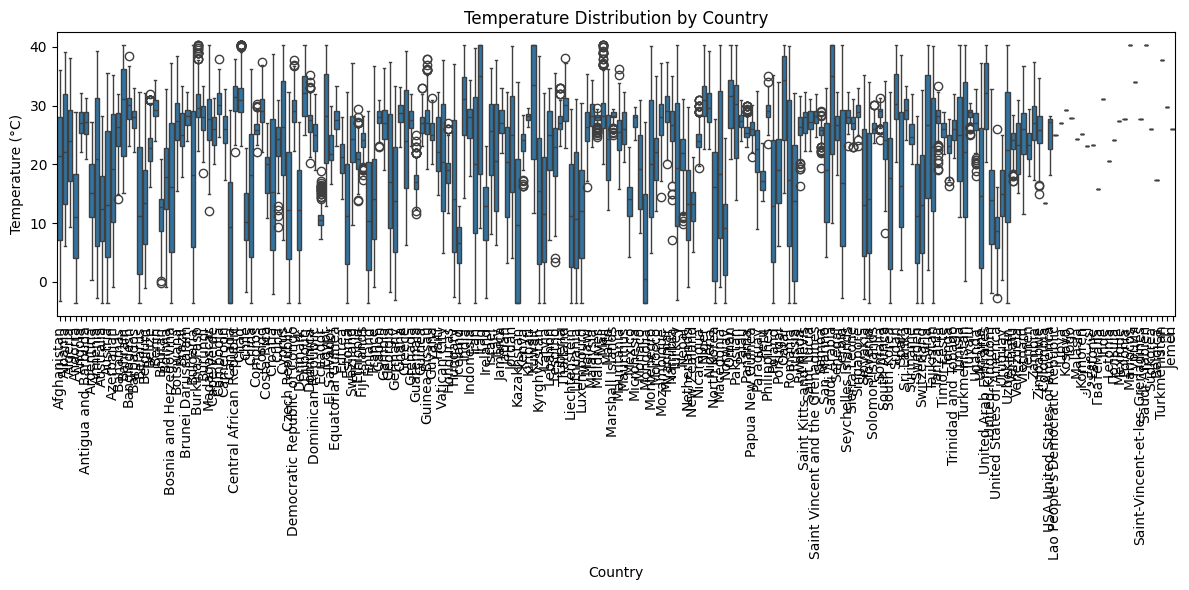

In [7]:
 # Cell 7: Unique Analyses

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Climate Analysis: Average Temperature by Country
if 'country' in df.columns:
    country_temp = df.groupby('country')['temperature_celsius'].mean().sort_values()
    plt.figure(figsize=(12,8))
    country_temp.plot(kind='bar')
    plt.title("Average Temperature (°C) by Country")
    plt.xlabel("Country")
    plt.ylabel("Average Temperature (°C)")
    plt.tight_layout()
    plt.show()

# 2. Environmental Impact: Correlation between Air Quality & Weather Parameters
air_quality_cols = [col for col in df.columns if 'air_quality' in col]
weather_params = ['temperature_celsius', 'humidity', 'precip_mm']
if set(air_quality_cols + weather_params).issubset(df.columns):
    corr_data = df[air_quality_cols + weather_params].corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_data, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation between Air Quality and Weather Parameters")
    plt.show()

# 3. Feature Importance: Predicting Temperature using Random Forest
# Select predictor features (modify as available)
features = ['humidity', 'wind_mph', 'pressure_mb', 'cloud', 'precip_mm']
features = [f for f in features if f in df.columns]
target = 'temperature_celsius'
if features:
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Plot feature importances
    importances = pd.Series(rf.feature_importances_, index=features).sort_values()
    plt.figure(figsize=(8,6))
    importances.plot(kind='barh')
    plt.title("Feature Importance for Predicting Temperature")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()
else:
    print("No features available for feature importance analysis.")

# 4. Spatial Analysis: Geographical Distribution of Temperature
if 'latitude' in df.columns and 'longitude' in df.columns:
    plt.figure(figsize=(10,8))
    sc = plt.scatter(df['longitude'], df['latitude'], c=df['temperature_celsius'],
                     cmap='viridis', alpha=0.6)
    plt.colorbar(sc, label="Temperature (°C)")
    plt.title("Geographical Distribution of Temperature")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# 5. Geographical Patterns: Temperature Distribution by Country
if 'country' in df.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='country', y='temperature_celsius', data=df)
    plt.title("Temperature Distribution by Country")
    plt.xlabel("Country")
    plt.ylabel("Temperature (°C)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [9]:
# Cell 8: Final Reporting and Dashboard Summary

print("Final Reporting Summary:")
print("1. Data cleaning: Missing values, outlier capping, date conversion, and normalization were completed.")
print("2. EDA: Trends in temperature and precipitation, and correlations among features were visualized.")
print("3. Model Building: A time series ARIMA forecast was built and evaluated using MSE, MAE, and RMSE.")
print("4. Advanced EDA: Anomaly detection via Isolation Forest was implemented.")
print("5. Forecasting: Multiple models (ARIMA and Exponential Smoothing) were compared, and an ensemble forecast was created.")
print("6. Unique Analyses: Climate patterns, environmental impact, feature importance, spatial analysis, and geographical patterns were explored.")



Final Reporting Summary:
1. Data cleaning: Missing values, outlier capping, date conversion, and normalization were completed.
2. EDA: Trends in temperature and precipitation, and correlations among features were visualized.
3. Model Building: A time series ARIMA forecast was built and evaluated using MSE, MAE, and RMSE.
4. Advanced EDA: Anomaly detection via Isolation Forest was implemented.
5. Forecasting: Multiple models (ARIMA and Exponential Smoothing) were compared, and an ensemble forecast was created.
6. Unique Analyses: Climate patterns, environmental impact, feature importance, spatial analysis, and geographical patterns were explored.
